In [1]:
#Imports
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
df = pd.read_csv("FXBTUSD-1m-data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.index = df.datetime

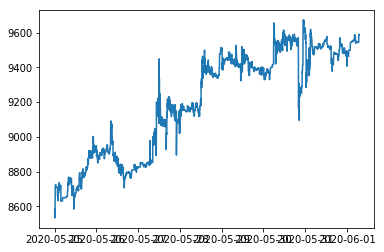

In [3]:
plt.plot(df.close)

In [4]:
upper, middle, lower = talib.BBANDS(df.close.values, timeperiod=100, nbdevup=2, nbdevdn=2, matype=0)

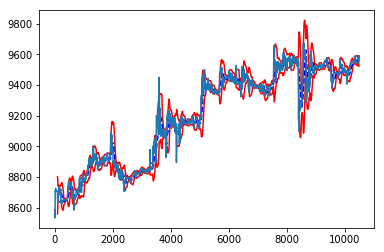

In [5]:
plt.figure()
plt.plot(upper, 'r')
plt.plot(lower, 'r')
plt.plot(middle, 'b--')
plt.plot(df.close.values)

In [6]:
buys = (df.close.values < lower) * lower
sells = (df.close.values > upper) * upper
buys[buys==0] = np.nan
sells[sells==0] = np.nan

/Users/jamescopperthwaite/opt/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/jamescopperthwaite/opt/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


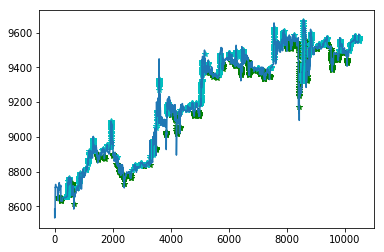

In [7]:
plt.figure()
plt.plot(buys, "g*")
plt.plot(sells, 'c*')
#plt.plot(upper, 'r')
#plt.plot(lower, 'r')
#plt.plot(middle, 'b--')
plt.plot(df.close.values)

In [78]:
df = pd.read_csv("FaXBTUSD-1m-data.csv")

In [9]:
df.head()

,datetime,close,foreignNotional,high,homeNotional,lastSize,low,open,turnover,volume,openinterest,time
0,2020-01-01 00:00:00,7162.0,1006.0,7162.5,0.140458,6.0,7162.0,7162.5,14045778,1006,7162.2977,00:00:00
1,2020-01-01 00:01:00,7162.5,4614.0,7162.5,0.644238,1000.0,7162.0,7162.0,64423781,4614,7162.2977,00:01:00
2,2020-01-01 00:02:00,7159.0,11933.0,7162.0,1.666587,1.0,7159.0,7162.5,166658651,11933,7160.2463,00:02:00
3,2020-01-01 00:03:00,7159.0,0.0,7159.0,0.000000,NaN,7159.0,7159.0,0,0,NaN,00:03:00
4,2020-01-01 00:04:00,7159.0,4055.0,7159.0,0.566402,1176.0,7159.0,7159.0,56640240,4055,7159.0000,00:04:00


In [10]:
df.tail()

,datetime,close,foreignNotional,high,homeNotional,lastSize,low,open,turnover,volume,openinterest,time
262495,2020-07-01 06:55:00,9146.5,0.0,9146.5,0.000000,NaN,9146.5,9146.5,0,0,NaN,06:55:00
262496,2020-07-01 06:56:00,9146.0,6.0,9146.0,0.000656,6.0,9146.0,9146.5,65604,6,9146.0,06:56:00
262497,2020-07-01 06:57:00,9146.5,6.0,9146.5,0.000656,6.0,9146.5,9146.0,65598,6,9146.5,06:57:00
262498,2020-07-01 06:58:00,9146.5,9.0,9146.5,0.000984,4.0,9146.5,9146.5,98397,9,9146.5,06:58:00
262499,2020-07-01 06:59:00,9146.0,7.0,9146.0,0.000765,7.0,9146.0,9146.5,76538,7,9146.0,06:59:00


In [79]:
df.index = pd.to_datetime(df.datetime)
C = df.close.resample('3H', convention='end').last()
O = df.open.resample('3H', convention='end').first()
H = df.high.resample('3H', convention='end').max()
L = df.low.resample('3H', convention='end').min()
V = df.volume.resample('3H', convention='end').sum()
l_ret = np.log(C.values) - np.log(O.values)

In [12]:
new_df = pd.concat([O,H,L,C,V], axis=1)
new_df["l_ret"] = l_ret

In [80]:
#plt.figure()
#plt.hist(l_ret, bins=50)
q75, q25 = np.percentile(l_ret, [75 ,25])
buy = np.zeros(len(l_ret))

bplot = np.zeros(len(l_ret))
bplot[:] = np.nan
bplot[l_ret >= q75] = 1
bplot = bplot* C.values

splot = np.zeros(len(l_ret))
splot[:] = np.nan
splot[l_ret <= q25] = 1
splot = splot* C.values

buy[l_ret <= q25] = -1
buy[l_ret >= q75] = 1
new_df["buy"] = buy
new_df["bplot"] = bplot
new_df["splot"] = splot

<IPython.core.display.Javascript object>


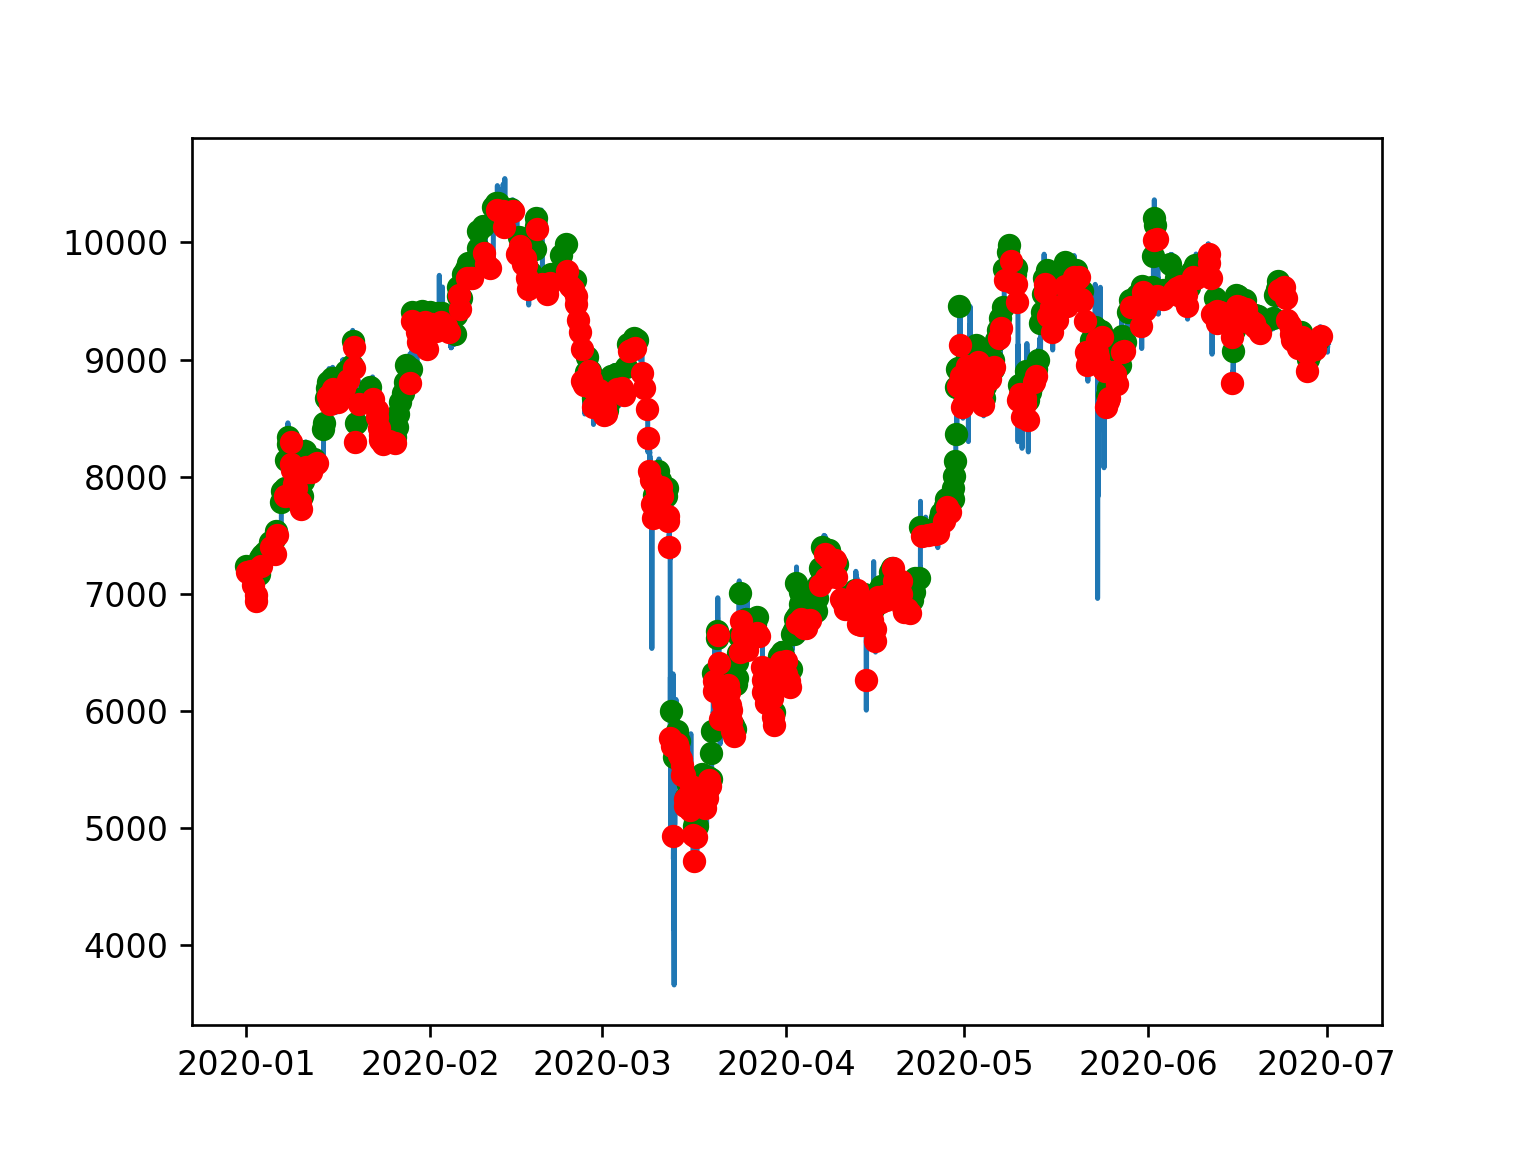

In [20]:
%matplotlib notebook
plt.figure()
plt.plot(df.close)
plt.plot(new_df.bplot, "go")
plt.plot(new_df.splot, "ro")

In [24]:
from xgboost import XGBRegressor


In [25]:
model = XGBRegressor()

In [26]:
df["l_ret"] = np.log(df.close.values) - np.log(df.close.shift(240).values)

In [33]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [82]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions
 
# load the dataset
s = df.close# transform the time series data into supervised learning
data = series_to_supervised(df[["open", "high", "low", "close"]].values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

>expected=9146.0, predicted=9146.7
>expected=9146.5, predicted=9145.9
>expected=9146.5, predicted=9147.2


KeyboardInterrupt: 

In [48]:
df.shape[1]

13

In [54]:
data = series_to_supervised(df[["open", "high", "low", "close", "l_ret"]].values, n_in=100)
data.shape

(262160, 505)

In [58]:
d = df[["open", "high", "low", "close", "l_ret"]].values

In [61]:
n_vars = d.shape[1]
df = pd.DataFrame(d)
cols = list()
# input sequence (t-n, ... t-1)
for i in range(100, 0, -1):
    cols.append(df.shift(i))
print(cols)
# forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(df.shift(-i))
print(cols)
# put it all together
agg = pd.concat(cols, axis=1)
# drop rows with NaN values
if dropnan:
    agg.dropna(inplace=True)
agg.values

[             0       1       2       3         4
0          NaN     NaN     NaN     NaN       NaN
1          NaN     NaN     NaN     NaN       NaN
2          NaN     NaN     NaN     NaN       NaN
3          NaN     NaN     NaN     NaN       NaN
4          NaN     NaN     NaN     NaN       NaN
5          NaN     NaN     NaN     NaN       NaN
6          NaN     NaN     NaN     NaN       NaN
7          NaN     NaN     NaN     NaN       NaN
8          NaN     NaN     NaN     NaN       NaN
9          NaN     NaN     NaN     NaN       NaN
10         NaN     NaN     NaN     NaN       NaN
11         NaN     NaN     NaN     NaN       NaN
12         NaN     NaN     NaN     NaN       NaN
13         NaN     NaN     NaN     NaN       NaN
14         NaN     NaN     NaN     NaN       NaN
15         NaN     NaN     NaN     NaN       NaN
16         NaN     NaN     NaN     NaN       NaN
17         NaN     NaN     NaN     NaN       NaN
18         NaN     NaN     NaN     NaN       NaN
19         NaN     

[             0       1       2       3         4
0          NaN     NaN     NaN     NaN       NaN
1          NaN     NaN     NaN     NaN       NaN
2          NaN     NaN     NaN     NaN       NaN
3          NaN     NaN     NaN     NaN       NaN
4          NaN     NaN     NaN     NaN       NaN
5          NaN     NaN     NaN     NaN       NaN
6          NaN     NaN     NaN     NaN       NaN
7          NaN     NaN     NaN     NaN       NaN
8          NaN     NaN     NaN     NaN       NaN
9          NaN     NaN     NaN     NaN       NaN
10         NaN     NaN     NaN     NaN       NaN
11         NaN     NaN     NaN     NaN       NaN
12         NaN     NaN     NaN     NaN       NaN
13         NaN     NaN     NaN     NaN       NaN
14         NaN     NaN     NaN     NaN       NaN
15         NaN     NaN     NaN     NaN       NaN
16         NaN     NaN     NaN     NaN       NaN
17         NaN     NaN     NaN     NaN       NaN
18         NaN     NaN     NaN     NaN       NaN
19         NaN     

NameError: name 'dropnan' is not defined

In [84]:
pd.DataFrame(agg.values).shape

(262500, 505)

In [73]:
train = d

# transform list into array
train = np.asarray(train)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
testX, testy = test[0, :-1], test[0, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# make a one-step prediction
yhat = model.predict(np.asarray([testX]))
yhat[0]

0.5

In [86]:
trainy.shape

(262500,)

In [81]:
df

,datetime,close,foreignNotional,high,homeNotional,lastSize,low,open,turnover,volume,openinterest,time
datetime,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,7162.0,1006.0,7162.5,0.140458,6.0,7162.0,7162.5,14045778,1006,7162.2977,00:00:00
2020-01-01 00:01:00,2020-01-01 00:01:00,7162.5,4614.0,7162.5,0.644238,1000.0,7162.0,7162.0,64423781,4614,7162.2977,00:01:00
2020-01-01 00:02:00,2020-01-01 00:02:00,7159.0,11933.0,7162.0,1.666587,1.0,7159.0,7162.5,166658651,11933,7160.2463,00:02:00
2020-01-01 00:03:00,2020-01-01 00:03:00,7159.0,0.0,7159.0,0.000000,NaN,7159.0,7159.0,0,0,NaN,00:03:00
2020-01-01 00:04:00,2020-01-01 00:04:00,7159.0,4055.0,7159.0,0.566402,1176.0,7159.0,7159.0,56640240,4055,7159.0000,00:04:00
2020-01-01 00:05:00,2020-01-01 00:05:00,7159.0,0.0,7159.0,0.000000,NaN,7159.0,7159.0,0,0,NaN,00:05:00
2020-01-01 00:06:00,2020-01-01 00:06:00,7158.5,2247.0,7158.5,0.313883,159.0,7158.5,7159.0,31388343,2247,7158.5000,00:06:00
2020-01-01 00:07:00,2020-01-01 00:07:00,7159.0,1000.0,7159.0,0.139680,1000.0,7159.0,7158.5,13968000,1000,7159.0000,00:07:00
2020-01-01 00:08:00,2020-01-01 00:08:00,7159.0,2009.0,7159.0,0.280627,2.0,7158.5,7159.0,28062712,2009,7159.2211,00:08:00
